In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

RANDOM_SEED = 42

%matplotlib inline

In [3]:
import nltk
from nltk.corpus import stopwords
import string

In [4]:
def load_data():
    df_train = pd.read_csv('./data/train.csv')
    df_test = pd.read_csv('./data/test.csv')
    return df_train, df_test

df_train, df_test = load_data()

In [5]:
label_dic = {'EAP': 0, 'HPL': 1, 'MWS': 2}
df_train['label'] = df_train['author'].map(label_dic)


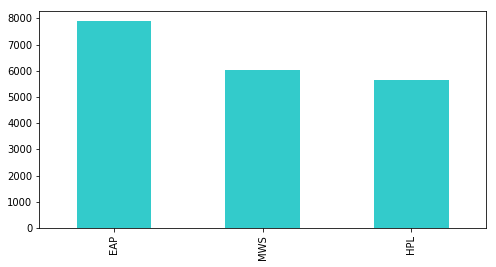

In [6]:
plt.figure(figsize=(8,4))
df_train['author'].value_counts().plot.bar(alpha=0.8, color='c')

In [7]:
df_train['EAP'] = df_train['author'].apply(lambda x : 1 if x == 'EAP' else 0 )
df_train['HPL'] = df_train['author'].apply(lambda x : 1 if x == 'HPL' else 0 )
df_train['MWS'] = df_train['author'].apply(lambda x : 1 if x == 'MWS' else 0 )
df_train.head(5)

,id,text,author,label,EAP,HPL,MWS
0,id26305,"This process, however, afforded me no means of...",EAP,0,1,0,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1,0,1,0
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0,1,0,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2,0,0,1
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1,0,1,0


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
from nltk.stem.porter import PorterStemmer

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [10]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
stop = stopwords.words('english')

param_grid = [{
  #  'vect_ngram_range':[(1,1)],
  #  'vect_stop_words' : [stop, None],
  #  'vect__tokenizer' : [tokenizer, tokenizer_porter],
    'clf__penalty' : [ 'l1', 'l2'],
    'clf__C': [1.0, 10.0, 100.0 ]},
    {
  #   'vect_ngram_range' :[(1,1)],
  #   'vect_stop_words' : [stop, None],
  #   'vect__tokenizer' : [tokenizer, tokenizer_porter],
  #   'vect__use_idf' : [False],
  #   'vect__norm' :[None],
     'clf__penalty' : ['l1', 'l2'],
     'clf__C' : [1.0, 10.0, 100.0]

    }]
lr_tfidf = Pipeline([('vect', tfidf),
                    ('clf', LogisticRegression(random_state=RANDOM_SEED))])
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [11]:
from sklearn.naive_bayes import MultinomialNB

In [12]:
X_text = df_train['text'].values
y = df_train['EAP'].values
X_train, X_test, y_train, y_test = train_test_split(X_text, y, random_state=RANDOM_SEED)

In [13]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}, {'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [14]:
gs_lr_tfidf.best_estimator_

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [15]:
gs_lr_tfidf.score(X_test, y_test)

0.85740551583248215

In [16]:
test_proba = gs_lr_tfidf.predict_proba(X_test)
test_proba.shape

(4895, 2)

In [17]:
test_proba[:5]

array([[ 0.00792012,  0.99207988],
       [ 0.87800324,  0.12199676],
       [ 0.78911303,  0.21088697],
       [ 0.05807303,  0.94192697],
       [ 0.48574013,  0.51425987]])

In [18]:
gs_lr_tfidf.predict(X_test)[:5]

array([1, 0, 0, 1, 1])

In [19]:
X_submit = df_test['text'].values

In [20]:
submit_eap_proba = gs_lr_tfidf.predict_proba(X_submit)
submit_eap_proba[:5]

array([[ 0.67184741,  0.32815259],
       [ 0.0672106 ,  0.9327894 ],
       [ 0.87472075,  0.12527925],
       [ 0.27578916,  0.72421084],
       [ 0.17498067,  0.82501933]])

In [21]:
X_text = df_train['text'].values
y = df_train['HPL'].values
X_train, X_test, y_train, y_test = train_test_split(X_text, y, random_state=RANDOM_SEED)

In [22]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}, {'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [23]:
gs_lr_tfidf.score(X_test, y_test)

0.89785495403472937

In [24]:
submit_hpl_proba = gs_lr_tfidf.predict_proba(X_submit)
submit_hpl_proba[:5]

array([[ 0.99027945,  0.00972055],
       [ 0.92331055,  0.07668945],
       [ 0.05782448,  0.94217552],
       [ 0.72656862,  0.27343138],
       [ 0.94186055,  0.05813945]])

In [25]:
X_text = df_train['text'].values
y = df_train['MWS'].values
X_train, X_test, y_train, y_test = train_test_split(X_text, y, random_state=RANDOM_SEED)

In [26]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}, {'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1)

In [27]:
gs_lr_tfidf.score(X_test, y_test)

0.8894790602655771

In [28]:
submit_mws_proba = gs_lr_tfidf.predict_proba(X_submit)
submit_mws_proba[:5]

array([[ 0.20923464,  0.79076536],
       [ 0.98679297,  0.01320703],
       [ 0.98284434,  0.01715566],
       [ 0.98007365,  0.01992635],
       [ 0.87362636,  0.12637364]])

In [29]:
submit_all_proba = np.concatenate(
    (submit_eap_proba, submit_hpl_proba, submit_mws_proba), axis=1)
submit_all_proba.shape

(8392, 6)

In [30]:
submit_eap_proba.shape

(8392, 2)

In [31]:
np.argmax(submit_eap_proba, axis=1).shape

(8392,)

In [32]:
df_submit_predict = pd.DataFrame(submit_all_proba, columns = ['EAP0','EAP1','HPL0','HPL1','MWS0','MWS1'])
df_submit_predict.head(3)

,EAP0,EAP1,HPL0,HPL1,MWS0,MWS1
0,0.671847,0.328153,0.990279,0.009721,0.209235,0.790765
1,0.067211,0.932789,0.923311,0.076689,0.986793,0.013207
2,0.874721,0.125279,0.057824,0.942176,0.982844,0.017156


In [33]:
df_submit_predict['EAP'] = np.argmax(submit_eap_proba, axis=1)
df_submit_predict['HPL'] = np.argmax(submit_hpl_proba, axis=1)
df_submit_predict['MWS'] = np.argmax(submit_mws_proba, axis=1)
df_submit_predict['sum_chcek'] = df_submit_predict['EAP'] + df_submit_predict['HPL'] +df_submit_predict['MWS']
df_submit_predict.head(30)

,EAP0,EAP1,HPL0,HPL1,MWS0,MWS1,EAP,HPL,MWS,sum_chcek
0,0.671847,0.328153,0.990279,0.009721,0.209235,0.790765,0,0,1,1
1,0.067211,0.932789,0.923311,0.076689,0.986793,0.013207,1,0,0,1
2,0.874721,0.125279,0.057824,0.942176,0.982844,0.017156,0,1,0,1
3,0.275789,0.724211,0.726569,0.273431,0.980074,0.019926,1,0,0,1
4,0.174981,0.825019,0.941861,0.058139,0.873626,0.126374,1,0,0,1
5,0.209116,0.790884,0.698548,0.301452,0.988699,0.011301,1,0,0,1
6,0.027003,0.972997,0.945026,0.054974,0.997844,0.002156,1,0,0,1
7,0.950833,0.049167,0.668401,0.331599,0.749355,0.250645,0,0,0,0
8,0.007038,0.992962,0.974601,0.025399,0.997816,0.002184,1,0,0,1
9,0.018817,0.981183,0.993302,0.006698,0.963290,0.036710,1,0,0,1


In [34]:
df_submit_predict[df_submit_predict['sum_chcek']==2].shape

(255, 10)

In [35]:
df_submit_predict[df_submit_predict['sum_chcek']==0].shape

(1142, 10)

In [36]:
df_submit_predict[df_submit_predict['sum_chcek']==3].shape

(0, 10)

In [39]:
df_submit_pred2 = pd.DataFrame(df_submit_predict[['EAP1','HPL1', 'MWS1']] , columns = ['EAP1','HPL1','MWS1'])
df_submit_pred2.head()

,EAP1,HPL1,MWS1
0,0.328153,0.009721,0.790765
1,0.932789,0.076689,0.013207
2,0.125279,0.942176,0.017156
3,0.724211,0.273431,0.019926
4,0.825019,0.058139,0.126374


In [40]:
df_submit_pred2['EAP0'] = df_submit_pred2['EAP1'] / df_submit_pred2.sum(axis=1)
df_submit_pred2['HPL0'] = df_submit_pred2['HPL1'] / df_submit_pred2.sum(axis=1)
df_submit_pred2['MWS0'] = df_submit_pred2['MWS1'] / df_submit_pred2.sum(axis=1)

df_submit_pred2

,EAP1,HPL1,MWS1,EAP0,HPL0,MWS0
0,0.328153,0.009721,0.790765,0.290751,0.006848,0.554441
1,0.932789,0.076689,0.013207,0.912098,0.039637,0.006689
2,0.125279,0.942176,0.017156,0.115506,0.785070,0.008642
3,0.724211,0.273431,0.019926,0.711707,0.158119,0.010558
4,0.825019,0.058139,0.126374,0.817229,0.031827,0.067994
5,0.790884,0.301452,0.011301,0.716616,0.165610,0.005691
6,0.972997,0.054974,0.002156,0.944540,0.027840,0.001077
7,0.049167,0.331599,0.250645,0.077869,0.467514,0.212989
8,0.992962,0.025399,0.002184,0.972972,0.012741,0.001089
9,0.981183,0.006698,0.036710,0.957633,0.003379,0.018488


In [41]:
df_submit_sample = pd.read_csv('./data/sample_submission.csv')
df_submit_sample.head(3)

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698


In [42]:
df_submit_sample['EAP'] = df_submit_pred2['EAP0']
df_submit_sample['HPL'] = df_submit_pred2['HPL0']
df_submit_sample['MWS'] = df_submit_pred2['MWS0']

In [43]:
df_submit_sample.to_csv('./data/output1105.csv', index=False)